In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from numba import njit

## Loss functions, gradients and step sizes

In [ ]:
class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    def grad(self, w):
        return self.X.T @ (self.X @ w - self.y) / self.n + self.lbda * w
    
    def f(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.

    def f_i(self, i, w):
        return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.
    
    def grad_i(self, i, w):
        return self.X[i] * (self.X[i] @ w - self.y[i]) + self.lbda * w

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        return L

In [ ]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    def grad(self, w):
        bAx = self.y * np.dot(self.X, w)
        return  -self.X.T @ (self.y * (1 + np.exp(bAx))**(-1) ) / self.X.shape[0] + self.lbda * w

    def f(self, w):
        bAx = self.y * np.dot(self.X, w)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(w) ** 2 / 2.
    
    def f_i(self,i, w):
        bAx_i = self.y[i] * np.dot(self.X[i], w)
        return np.log(1. + np.exp(- bAx_i)) + self.lbda * norm(w) ** 2 / 2.
    
    def grad_i(self, i, w):
        a_i = self.X[i]
        b_i = self.y[i]
        return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, w))) + self.lbda * w


    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = norm(self.X, ord=2) ** 2  / (4. * self.n) + self.lbda
        return L

## Dataset

In [ ]:
import scipy.io as sio
mat_contents = sio.loadmat("data/data_orsay_2017.mat")

X = mat_contents["Xtrain"]
y = mat_contents["ytrain"].flatten()

Xtest = mat_contents["Xtest"]
ytest = mat_contents["ytest"].flatten()

n,d = X.shape

## Implementations

In [ ]:
def Alg(w_init, log_lin, step=1., a=1, lbda=0, K=1, n_iter=100, store_every=100):
    """SAGA algorithm."""
    w = w_init.copy()
    model = log_lin(X, y, lbda)
    test_model = log_lin(Xtest,ytest, lbda)
    w_min, obj_min, _ = fmin_l_bfgs_b(model.f, 
                                      w_init, 
                                      model.grad, 
                                      args=(), 
                                      pgtol=1e-30, 
                                      factr =1e-30)
    momentum = np.zeros(d)
    objectives = []
    train = []
    # Current objective
    objectives.append(test_model.f(w))
    train.append(model.f(w))
    for idx in range(n_iter):
        if idx==0 :
          momentum = model.grad(w) 
        else :
          momentum = (1-a)*momentum + a * model.grad(w)
        i = indices[idx] #choice of batch i.e. helper h
        w_loc = w
        for k in range(K):
          gradi_w =  model.grad_i(i, w)
          gradi_wloc = model.grad_i(i, w_loc)
          w_loc -= step * (gradi_wloc - gradi_w + momentum)
        # Update w.
        w = w_loc
        if idx % store_every == 0:
            objectives.append(test_model.f(w))
            train.append(model.f(w))
    return w, np.array(objectives)-obj_min, np.array(train)-obj_min

In [ ]:
##Setup number of iterations
datapasses = 10  # number of sweeps through all the data. This means that there will datapasses*n stochastic gradient updates
niters = int(datapasses * n)
indices = np.random.randint(0, n, niters)

## Comparaison

In [ ]:
linlog = LinReg #LogReg  #choice of the model : linear regression or logistic regression
mu = 1e-5 #1e-1 # choice of the regularization parameter
w_init = np.zeros(d)

In [ ]:
step = 1e-3
a = 1
K = 1
w_alg1, obj_alg1, train_alg1 = Alg(w_init, linlog, step, a, mu, K, niters)

In [ ]:
step = 1e-3
a = 1
K = 3
w_alg3, obj_alg3, train_alg3 = Alg(w_init, linlog, step, a, mu, K, niters)

In [ ]:
step = 1e-3
a = 1
K = 5
w_alg5, obj_alg5, train_alg5 = Alg(w_init, linlog, step, a, mu, K, niters)

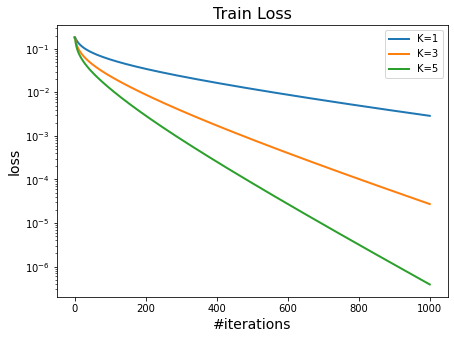

In [ ]:
# training loss on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(train_alg1 , label="K=1", lw=2)
plt.semilogy(train_alg3 , label="K=3", lw=2)
plt.semilogy(train_alg5 , label="K=5", lw=2)
plt.title("Train Loss", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.legend()
plt.savefig("images/train1")

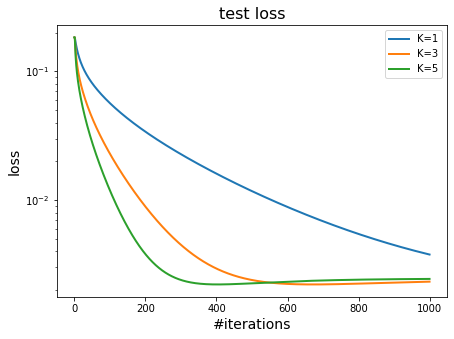

In [ ]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_alg1 , label="K=1", lw=2)
plt.semilogy(obj_alg3 , label="K=3", lw=2)
plt.semilogy(obj_alg5 , label="K=5", lw=2)
plt.title("test loss", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.legend()
plt.savefig("images/test1")

## Reusing only one batch

In [ ]:
def OneBatchAlg(w_init, log_lin, step=1., a=1, lbda=0, K=1, n_iter=100, store_every=100):
    """SAGA algorithm."""
    w = w_init.copy()
    model = log_lin(X, y, lbda)
    test_model = log_lin(Xtest,ytest, lbda)
    w_min, obj_min, _ = fmin_l_bfgs_b(model.f, 
                                      w_init, 
                                      model.grad, 
                                      args=(), 
                                      pgtol=1e-30, 
                                      factr =1e-30)
    momentum = np.zeros(d)
    objectives = []
    train = []
    # Current objective
    objectives.append(test_model.f(w))
    train.append(model.f(w))
    i = indices[np.random.randint(0, n)] #choice of batch i.e. helper h
    for idx in range(n_iter):
        if idx==0 :
          momentum = model.grad(w) 
        else :
          momentum = (1-a)*momentum + a * model.grad(w)
        w_loc = w
        for k in range(K):
          gradi_w =  model.grad_i(i, w)
          gradi_wloc = model.grad_i(i, w_loc)
          w_loc -= step * (gradi_wloc - gradi_w + momentum)
        # Update w.
        w = w_loc
        if idx % store_every == 0:
            objectives.append(test_model.f(w))
            train.append(model.f(w))
    return w, np.array(objectives)-obj_min, np.array(train)-obj_min

In [ ]:
step = 1e-3
a = 1
K = 1
w_alg1, obj_alg1, train_alg1 = OneBatchAlg(w_init, linlog, step, a, mu, K, niters)

In [ ]:
step = 1e-3
a = 1
K = 3
w_alg3, obj_alg3, train_alg3 = OneBatchAlg(w_init, linlog, step, a, mu, K, niters)

In [ ]:
step = 1e-3
a = 1
K = 5
w_alg5, obj_alg5, train_alg5 = OneBatchAlg(w_init, linlog, step, a, mu, K, niters)

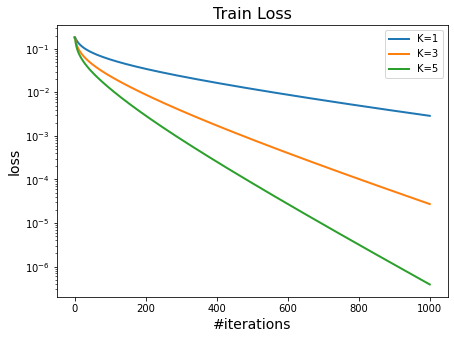

In [ ]:
# training loss on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(train_alg1 , label="K=1", lw=2)
plt.semilogy(train_alg3 , label="K=3", lw=2)
plt.semilogy(train_alg5 , label="K=5", lw=2)
plt.title("Train Loss", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.legend()
plt.savefig("images/train3(Onebatch)")

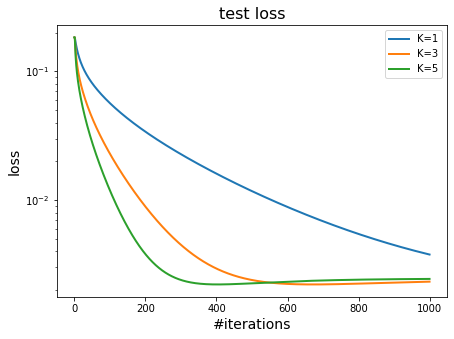

In [ ]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_alg1 , label="K=1", lw=2)
plt.semilogy(obj_alg3 , label="K=3", lw=2)
plt.semilogy(obj_alg5 , label="K=5", lw=2)
plt.title("test loss", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.legend()
plt.savefig("drive/MyDrive/OptWithAuxInf/test3(OneBatch)")

## Noisy queries of f

In [ ]:
indicesf = np.random.randint(0, n, niters)

In [ ]:
indices[:10],indicesf[:10]

(array([3635, 5904, 4457, 4201, 2336, 4803, 3054, 2347, 5112, 6974]),
 array([5862,  986, 6865, 1512, 9890, 4151, 8196, 6680, 8967, 6143]))

In [ ]:
def NoisyAlg(w_init, log_lin, steps, a=1, lbda=0, K=1, n_iter=100, store_every=100):
    """SAGA algorithm."""
    w = w_init.copy()
    model = log_lin(X, y, lbda)
    test_model = log_lin(Xtest,ytest, lbda)
    w_min, obj_min, _ = fmin_l_bfgs_b(model.f, 
                                      w_init, 
                                      model.grad, 
                                      args=(), 
                                      pgtol=1e-30, 
                                      factr =1e-30)
    momentum = np.zeros(d)
    objectives = []
    train = []
    # Current objective
    objectives.append(test_model.f(w))
    train.append(model.f(w))
    for idx in range(n_iter):
        i_f = indicesf[idx]
        if idx==0 :
          momentum = model.grad_i(i_f,w) 
        else :
          momentum = (1-a)*momentum + a * model.grad_i(i_f,w)
        i_h = indices[idx] #choice of batch i.e. helper h
        w_loc = w
        for k in range(K):
          gradi_w =  model.grad_i(i_h, w)
          gradi_wloc = model.grad_i(i_h, w_loc)
          w_loc -= steps[idx] * (gradi_wloc - gradi_w + momentum)
        # Update w.
        w = w_loc
        if idx % store_every == 0:
            objectives.append(test_model.f(w))
            train.append(model.f(w))
    return w, np.array(objectives)-obj_min, np.array(train)-obj_min

In [ ]:
C = 1e-1
steps =list(map(lambda t : C / np.sqrt(t+1), np.arange(niters)) )

In [ ]:
a = 1
K = 1
w_alg1, obj_alg1, train_alg1 = NoisyAlg(w_init, linlog, steps, a, mu, K, niters)

In [ ]:
a = 0.01
K = 3
w_alg3, obj_alg3, train_alg3 = NoisyAlg(w_init, linlog, steps, a, mu, K, niters)

In [ ]:
a = 0.005
K = 5
w_alg5, obj_alg5, train_alg5 = NoisyAlg(w_init, linlog, steps, a, mu, K, niters)

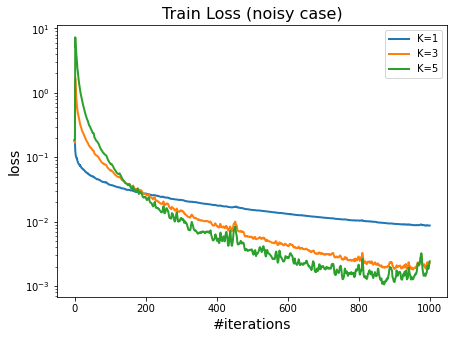

In [ ]:
# training loss on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(train_alg1 , label="K=1", lw=2)
plt.semilogy(train_alg3 , label="K=3", lw=2)
plt.semilogy(train_alg5 , label="K=5", lw=2)
plt.title("Train Loss (noisy case)", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.legend()
plt.savefig("images/train2(noisy)")

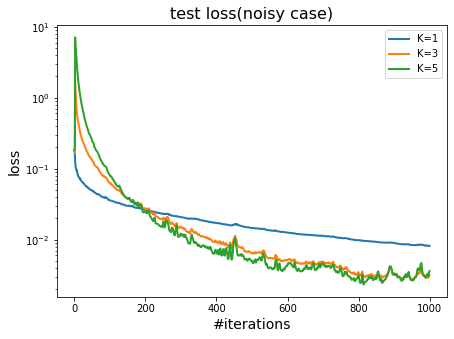

In [ ]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_alg1 , label="K=1", lw=2)
plt.semilogy(obj_alg3 , label="K=3", lw=2)
plt.semilogy(obj_alg5 , label="K=5", lw=2)
plt.title("test loss(noisy case)", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.legend()
plt.savefig("images/test2(noisy)")